In [1]:
import os
import sys

root = os.path.join('..')
sys.path.append(root)

In [2]:
import os

import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as VF
from torchattacks import AutoAttack

from utils.mlp import MLP
from utils.utils import ModelWithNormalization, dataloader, freeze

In [3]:
def show(imgs: torch.Tensor, labels: torch.Tensor) -> None:
    nrow = 2
    ncol = 10
    axes = plt.subplots(nrow, ncol, figsize=(5, 1), layout='constrained')[1]
    for r in range(nrow):
        for c in range(ncol):
            idx = (labels == c).nonzero(as_tuple=True)[0][r].item()
            img = imgs[idx, 0].cpu() # type: ignore
            ax = axes[r, c]
            ax.axis('off')
            ax.imshow(img, cmap='gray')
    plt.show()

def calc_acc(model: torch.nn.Module, imgs: torch.Tensor, labels: torch.Tensor) -> float:
    logits = model(imgs)
    predicted_labels = logits.max(1).indices == labels
    return predicted_labels.sum().item() / len(predicted_labels)

Clean imgs (examples)


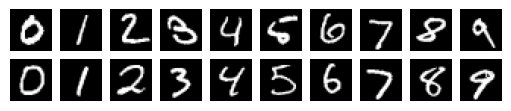

-------------------------------------------------
width 125
Clean accuracy: 95%
Adversarial imgs (examples)


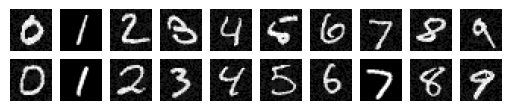

Adversarial accuracy: 14%
-------------------------------------------------
width 250
Clean accuracy: 96%
Adversarial imgs (examples)


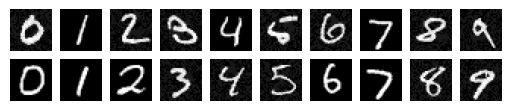

Adversarial accuracy: 50%
-------------------------------------------------
width 500
Clean accuracy: 98%
Adversarial imgs (examples)


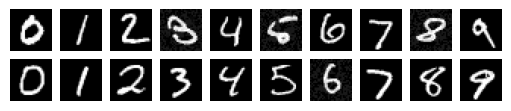

Adversarial accuracy: 81%
-------------------------------------------------
width 1000
Clean accuracy: 99%
Adversarial imgs (examples)


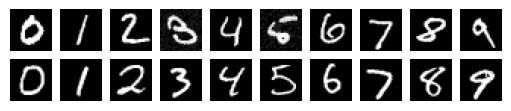

Adversarial accuracy: 91%
-------------------------------------------------


In [4]:
device = 'cuda:0'

# load data
dataset_root = os.path.join(os.path.sep, 'root', 'datasets')
dataset = torchvision.datasets.MNIST(dataset_root, False, VF.ToTensor())
loader = dataloader(dataset, len(dataset), False)
imgs, labels = next(iter(loader))
imgs = imgs.to(device)
labels = labels.to(device)

# show clean img
print('Clean imgs (examples)')
show(imgs, labels)
print('-------------------------------------------------')

for width in [125, 250, 500, 1000]:
    print(f'width {width}')

    # define model
    model = MLP(784, width, 10, 5, True)
    model = ModelWithNormalization(model, [0.1307], [0.3081])
    model.to(device)

    # load weight
    weight_path = os.path.join(root, 'weights', f'width={width}.ckpt')
    weight = torch.load(weight_path, map_location=device)
    model.load_state_dict(weight)
    model = model.eval()
    freeze(model)

    # clean acc
    clean_acc = calc_acc(model, imgs, labels)
    print(f'Clean accuracy: {int(clean_acc*100)}%')

    # attack
    autoattack = AutoAttack(model, eps=0.1, seed=0)
    advs = autoattack(imgs, labels).detach()

    # show adv img
    print('Adversarial imgs (examples)')
    show(advs, labels)

    adv_acc = calc_acc(model, advs, labels)
    print(f'Adversarial accuracy: {int(adv_acc*100)}%')
    print('-------------------------------------------------')